In [136]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI

include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

pauli = [
    [0. 1.; 1. 0.],
    [0. -1.0im; 1.0im 0.],
    [1. 0.; 0. -1.]
]

3-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im -0.0 - 1.0im; 0.0 + 1.0im 0.0 + 0.0im]
 [1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im]

# Hamiltonian

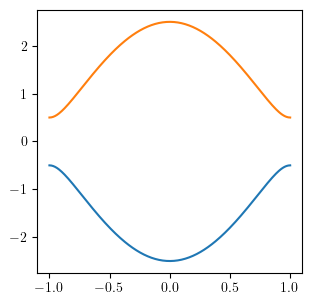

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x31e4e2340>
 PyObject <matplotlib.lines.Line2D object at 0x31e4e23d0>

In [375]:
function H(k::Vector{Float64}, m::Float64)
    return (
        pauli[1] * sin(k[1]) + pauli[2] * sin(k[2]) +
        pauli[3] * (m + cos(k[1]) + cos(k[2]))
    )
end

m = .5

nquantics = 8
ndiscretization = 2^nquantics
kvals = range(-pi, pi; length=ndiscretization)

bands = [eigvals(H([kx, ky], m)) for kx in kvals, ky in kvals]

fig, axs = subplots(figsize=(246/72, 246/72))
axs.plot(kvals / pi, bands[:, div(ndiscretization, 2)])

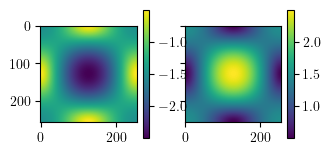

PyObject <matplotlib.colorbar.Colorbar object at 0x312eb1880>

In [376]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))
axs[1].imshow([b[1] for b in bands]) |> colorbar
axs[2].imshow([b[2] for b in bands]) |> colorbar

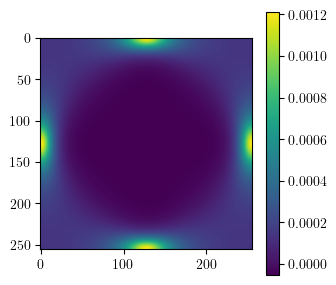

0.9999999999999972

In [377]:
fig, axs = subplots(figsize=(246/72, 246/72))
A = chern.berrycurvature_dets([H([kx, ky], m) for kx in kvals, ky in kvals], 2)
imshow(A) |> colorbar
sum(A) / 2pi

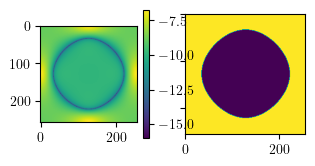

PyObject <matplotlib.image.AxesImage object at 0x314f10670>

In [378]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))
axs[1].imshow(log.(abs.(A)), vmin=-16) |> colorbar
axs[2].imshow(sign.(A))

In [379]:
function crossinterpolate_chern(
    ::Type{ValueType},
    f,
    localdims::Vector{Int},
    firstpivot::MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::SweepStrategies.SweepStrategy=SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    errornormalization::Union{Nothing,Float64}=nothing,
    verbosity::Int=0
) where {ValueType}
    tci = TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
    cherns = Float64[]
    ranks = Int[]
    N::Float64 = isnothing(errornormalization) ? abs(f(firstpivot)) : abs(errornormalization)

    # Start at two, because the constructor already added a pivot everywhere.
    for iter in 2:maxiter
        foward_sweep = (
            sweepstrategy == SweepStrategies.forward ||
            (sweepstrategy != SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end

        push!(errors, lastsweeppivoterror(tci) / N)
        push!(ranks, maximum(rank(tci)))
        if verbosity > 0 && mod(iter, 10) == 0
            println("rank= $(last(ranks)) , error= $(last(errors))")
        end
        if last(errors) < tolerance
            break
        end
    end

    return tci, ranks, errors
end

f(q) = chern.berrycurvature_quantics_dets(
    kindex -> H([kvals[kindex[1]], kvals[kindex[2]]], m),
    2, q, nquantics)

firstpivot = TCI.optfirstpivot(f, fill(2, 2*nquantics), fill(2, 2*nquantics))
tci, ranks, errors = TCI.crossinterpolate(
    Float64,
    f,
    fill(2, 2 * nquantics),
    firstpivot,
    tolerance=1e-4,
    maxiter=200
)

(TensorCrossInterpolation.TensorCI{Float64} with ranks 43, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  34, 35, 36, 37, 38, 39, 40, 41, 42, 43], [1.0044791349363131, 0.6133202184422386, 0.7248861119187867, 0.7886861814930372, 0.9189090875416932, 0.6423941771991445, 0.7227982875300327, 0.9308422706370737, 0.32384066788896176, 1.095787294409202  …  0.0006975266696115569, 0.0004769818186107555, 0.00027532894184434257, 0.0002679022649303243, 0.00014947795566969414, 0.0001650219408396736, 0.0001613733690250499, 0.00011007542002073033, 0.00010101842655732257, 7.25536262001035e-5])

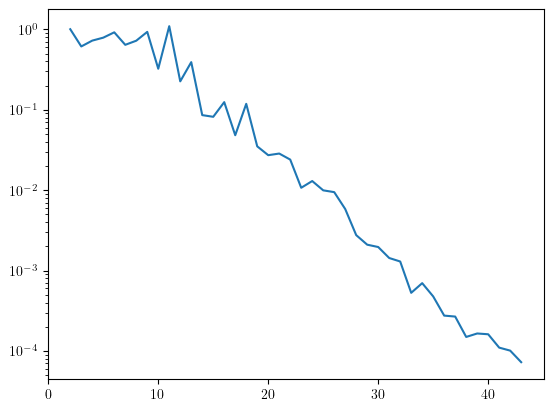

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2b1d46190>

In [380]:
semilogy(ranks, errors)

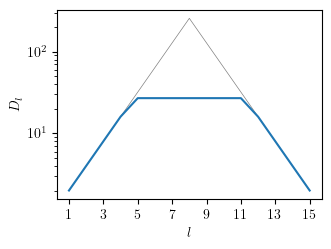

8-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.axis.XTick object at 0x321b70160>
 PyObject <matplotlib.axis.XTick object at 0x321b70130>
 PyObject <matplotlib.axis.XTick object at 0x321b508b0>
 PyObject <matplotlib.axis.XTick object at 0x321b9eb20>
 PyObject <matplotlib.axis.XTick object at 0x321ba7340>
 PyObject <matplotlib.axis.XTick object at 0x321ba7df0>
 PyObject <matplotlib.axis.XTick object at 0x321bac8e0>
 PyObject <matplotlib.axis.XTick object at 0x321bb43d0>

In [354]:
fig, ax = subplots(figsize=[246/72, 246/100])
ax.semilogy(1:2nquantics-1, maxlinkdim(2nquantics, 2)[2], color="gray", linewidth=0.5)
ax.semilogy(1:2nquantics-1, TCI.linkdims(tci))
ax.set_ylabel(L"$D_l$")
ax.set_xlabel(L"$l$")
ax.set_xticks(1:2:2nquantics-1)

In [322]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

qtt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(qtt, interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in eachindex(kvals), kyi in eachindex(kvals)
]

256×256 Matrix{Float64}:
 -2.48929e-17  -2.58831e-14  -1.92997e-15  …  5.79354e-17  5.37383e-16
  4.44768e-15   7.66633e-5    8.67446e-5      7.81585e-5   7.66633e-5
  2.28825e-16   7.62279e-5    8.01741e-5      7.64566e-5   7.67639e-5
  1.16556e-16   7.66986e-5    7.74911e-5      7.65265e-5   7.64651e-5
  1.84096e-6    7.75343e-5    7.67816e-5      7.7391e-5    7.65811e-5
  1.40389e-6    7.74037e-5    7.67926e-5   …  7.82469e-5   7.6781e-5
 -1.21135e-16   7.68399e-5    7.71807e-5      7.81562e-5   7.70186e-5
 -8.63588e-17   7.69107e-5    7.78991e-5      7.52293e-5   7.72653e-5
 -5.54376e-17   7.69935e-5    7.66927e-5      7.69842e-5   7.74678e-5
  6.35604e-17   7.70883e-5    7.71662e-5      7.69432e-5   7.75969e-5
 -1.28527e-6    7.6825e-5     7.70619e-5   …  7.72312e-5   7.76469e-5
 -1.30303e-16   7.70842e-5    7.72189e-5      7.73551e-5   7.79418e-5
  9.74794e-7    7.74342e-5    7.74987e-5      7.71634e-5   7.78595e-5
  ⋮                                        ⋱               ⋮
  1.

vmin = max(min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...), -12) = -12.0
vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...) = 0.0


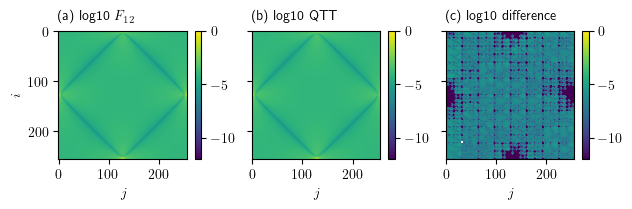

In [323]:
plottransform2(x) = log10(abs(x))
cmap = "viridis"

@show vmin = max(
    min(minimum.([plottransform2.(A), plottransform2.(qttdata)])...),
    -12)
@show vmax = max(0, maximum.([plottransform2.(A), plottransform2.(qttdata)])...)


fig, axs = subplots(ncols=3, figsize=(510/72, 120/72), sharey=true)
axs[1].imshow(plottransform2.(A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[2].imshow(plottransform2.(qttdata), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar
axs[3].imshow(plottransform2.(qttdata .- A), cmap=cmap, vmin=vmin, vmax=vmax) |> colorbar

labels = [
    "(a) log10 \$F_{12}\$",
    "(b) log10 QTT",
    "(c) log10 difference",
]

for (ax, label) in zip(axs, labels)
    ax.annotate(
        label,
        xy=(0, 1),
        xycoords="axes fraction",
        xytext=(0, 8),
        textcoords="offset points"
    )
end

axs[1].set_ylabel(L"$i$")
for ax in axs
    ax.set_xlabel(L"$j$")
end

In [324]:
function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

sumqtt(qtt) / 2pi, sum(qttdata) / 2pi, sum(A) / 2pi

(0.9998834673283571, 0.9998834673284744, 0.9999999999999857)